In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_float, filters
from skimage.util import pad
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

In [47]:
noisy_img=img_as_float(io.imread('15004n.png'))
img_noiseless=(img_as_float(io.imread('15004.png')))
print(noisy_img.shape)
padded= np.zeros((noisy_img.shape[0]+2,noisy_img.shape[1]+2,3))
padded[1:-1,1:-1, :]=noisy_img
padded.shape

(481, 321, 3)


(483, 323, 3)

In [48]:
def component_wise(I):
    r =filters.median(I[..., 0]) # FIXME: grab channel from image...
    g =filters.median(I[..., 1]) # FIXME
    b =filters.median(I[..., 2])# FIXME

    return np.stack([r, g, b], axis=2)


In [49]:
def find_median_index(Kernel):
    Y=np.tile(Kernel,(3,3,1,1))
        
    X=np.array([
            [np.tile(Kernel[l],(9,1)) for l in range(3)],
            [np.tile(Kernel[l+3],(9,1)) for l in range(3)],
            [np.tile(Kernel[l+6],(9,1)) for l in range(3)],

        ]) 
    D=[]
    Z =np.abs(X-Y)


    for l in Z:
        for m in l:                
            D.append(np.sum(m))

    return D.index(min(D))




def vector_median(I, radius):
    
    counter=0
    # accept image
    
    original_image_type=I.dtype.name
    
    if  original_image_type not in ['float64', 'uint8'] :
        return -1
    
    
    original_image_type_float = True
    if I.dtype.name == 'uint8':
        original_image_type_float=False
        img=I.astype('float')
    else:
        img= I
    
    # check type of image format
        # return -1 if image is not in either format
    # check if image is uint8
        # convert it to float
    
    n=radius*radius      
    
    """
    padding wiht zeros img and assigning to variable padded 
    SINCE THEY WILL HAVE A BIGGER MEDIAN, THEY WILL BE TAKEN CARE OF
    """
       
    padded= np.zeros((img.shape[0]+(radius*2),img.shape[1]+(radius*2),3))
    #padded=np.pad(img,pad_width=radius)
    
    
    
    padded[radius:-radius,radius:-radius,:]=img
    #real_radius=int(radius/2)

        
    # apply your vector median filter here
    
    
    #the shape of the padded image
    row, col=padded.shape[0],padded.shape[1]
    
    # doing it for all pixels
    for i in range(radius,row-radius):
        for j in range(radius,col-radius):
            
            # for one specific pixel (i,j), create a kernel around it      
            
            kernel= padded[i-radius:i+radius+1,j-radius:j+radius+1]            
            kernel=kernel.reshape((9,1,3))            
            kernel=np.array([k[0] for k in kernel])
            
            Y=np.tile(kernel,(3,3,1,1))
        
            X=np.array([
                    [np.tile(kernel[l],(9,1)) for l in range(3)],
                    [np.tile(kernel[l+3],(9,1)) for l in range(3)],
                    [np.tile(kernel[l+6],(9,1)) for l in range(3)],

                ]) 
            D=[]
            Z =np.abs(X-Y)


            for l in Z:
                for m in l:                
                    D.append(np.sum(m))
            
            median_index=D.index(min(D))
            
            # replace that particilar pixel by the median vector from the kernel
            padded[i][j]=kernel[median_index]
            
    padded = padded[radius:-radius,radius:-radius]

    # if the image was in the uint8 format, convert it back to uint8 befire returning it
    
    
    if original_image_type_float:
        return padded
    return padded.astype('uint8')
        

In [50]:
vmf_image= vector_median(noisy_img,1)
vmf_psnr=peak_signal_noise_ratio(img_noiseless,vmf_image)

lastest=vmf_image/2 + component_wise(noisy_img)/2 
latest_psnr=peak_signal_noise_ratio(img_noiseless,lastest)
print(vmf_psnr)
latest_psnr

23.201325576030804


24.82083408359316

In [55]:
component_filtered=component_wise(noisy_img)
road_image=np.copy(padded)
road_image.shape

(483, 323, 3)

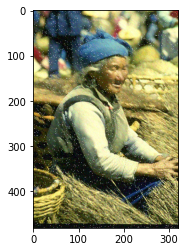

In [72]:
radius=1
for i in range(1,322):
    for j in range(1,482):    
        # for one specific pixel (i,j), create a kernel around it
       

        kernel= road_image[i-radius:i+radius+1,j-radius:j+radius+1]
        try:
            kernel=kernel.reshape((9,1,3))            
        except:
            continue
        kernel=np.array([k[0] for k in kernel])

        Y=np.tile(kernel,(3,3,1,1))

        X=np.array([
                [np.tile(kernel[l],(9,1)) for l in range(3)],
                [np.tile(kernel[l+3],(9,1)) for l in range(3)],
                [np.tile(kernel[l+6],(9,1)) for l in range(3)],

            ]) 
        D=[]
        Z =np.abs(X-Y)


        for l in Z:
            for m in l:                
                D.append(np.sum(m))

        median_index=D.index(min(D))
                 
        third_window=np.array([
            road_image[i-1][j-1],road_image[i-1][j],road_image[i-1][j+1],
            road_image[i][j-1],road_image[i][j+1],
            road_image[i+1][j-1],road_image[i+1][j],road_image[i+1][j+1]
            ])
        
        
        here=np.tile(road_image[i][j],(8,1))
        
        T=np.abs(third_window-here)
        DG=[]
        for m  in T:
            DG.append(np.sum(m))
        ROAD=np.sum(np.sort(DG)[0:4])/4
        
        VECTOR=[]
        
        VECTOR.append(ROAD-np.sum(window[median_index]))
        VECTOR.append(ROAD-np.sum(padded[i][j]))
        VECTOR.append(ROAD-np.sum(component_filtered[i-3][j-3]))
        #print(ROAD)
        last=VECTOR.index(min(VECTOR))
        #print(last)
        if last == 0:            
            road_image[i][j]=window[min_vector_index]
        elif last==2:
            road_image[i][j]=component_filtered[i-3][j-3]
        else:
            continue

road_image=road_image[1:-1,1:-1,:]
plt.imshow(road_image)

In [73]:
peak_signal_noise_ratio(img_noiseless,road_image)

18.40997093662232